In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rc('font', family = 'Malgun Gothic') # 그래프 글꼴 설정 (window)

# 2. 지도학습에 필요한 라이브러리를 호출
from sklearn.model_selection import train_test_split
from sklearn.compose        import make_column_transformer
from sklearn.impute import KNNImputer
from imblearn.pipeline      import pipeline
from imblearn.pipeline      import make_pipeline
from sklearn.impute         import SimpleImputer, KNNImputer
from sklearn.preprocessing  import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV    # 교차검증
from sklearn.metrics   import classification_report     # 평가
import pickle
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, explained_variance_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # Bagging Model 


In [2]:
path = 'C:/Users/DMC CONET/Desktop/초미세먼지프로젝트/ty_data/result_output/'

In [13]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69521 entries, 0 to 69520
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   날짜             69521 non-null  object 
 1   PM10           69521 non-null  int64  
 2   PM2.5          69521 non-null  int64  
 3   오존             69521 non-null  float64
 4   이산화질소          69521 non-null  float64
 5   일산화탄소          69521 non-null  float64
 6   아황산가스          69521 non-null  float64
 7   기온(°C)         69521 non-null  float64
 8   강수량(mm)        69521 non-null  float64
 9   풍속(m/s)        69521 non-null  float64
 10  풍향(16방위)       69521 non-null  int64  
 11  습도(%)          69521 non-null  float64
 12  증기압(hPa)       69521 non-null  float64
 13  이슬점온도(°C)      69521 non-null  float64
 14  현지기압(hPa)      69521 non-null  float64
 15  해면기압(hPa)      69521 non-null  float64
 16  지면온도(°C)       69521 non-null  float64
 17  5cm 지중온도(°C)   69521 non-null  float64
 18  10cm 지

https://xgboost.readthedocs.io/en/stable/parameter.html
https://www.geeksforgeeks.org/xgboost-for-regression/
https://dacon.io/en/competitions/official/235927/codeshare/6066

In [15]:
df_input = pd.read_csv(path + 'air_weather.csv')
df_input['날짜'] = pd.to_datetime(df_input['날짜'])

df_input['year'] = df_input['날짜'].apply(lambda x : x.year)
df_input['month'] = df_input['날짜'].apply(lambda x : x.month)
df_input['day'] = df_input['날짜'].apply(lambda x : x.day)
df_input['hour'] = df_input['날짜'].apply(lambda x: x.hour)

df_input.head()

,날짜,PM10,PM2.5,오존,이산화질소,일산화탄소,아황산가스,기온(°C),강수량(mm),풍속(m/s),...,해면기압(hPa),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),year,month,day,hour
0,2015-01-01 01:00:00,44,7,0.022,0.011,0.6,0.006,-7.4,0.0,4.7,...,1023.0,-4.5,-3.2,-1.3,0.1,0.8,2015,1,1,1
1,2015-01-01 02:00:00,57,10,0.022,0.010,0.6,0.006,-8.0,0.0,4.5,...,1022.9,-5.1,-3.7,-1.7,0.0,0.7,2015,1,1,2
2,2015-01-01 03:00:00,76,10,0.021,0.010,0.6,0.006,-8.4,0.0,3.8,...,1023.3,-5.5,-4.0,-1.9,0.0,0.7,2015,1,1,3
3,2015-01-01 04:00:00,86,11,0.022,0.009,0.6,0.006,-8.8,0.0,4.9,...,1023.6,-5.9,-4.4,-2.2,0.0,0.7,2015,1,1,4
4,2015-01-01 05:00:00,106,12,0.021,0.009,0.5,0.006,-9.1,0.0,5.7,...,1023.1,-6.3,-4.7,-2.4,0.0,0.7,2015,1,1,5


# Data split

In [17]:
import time

start = time.time()
df_input['6h_PM2.5'] = df_input['PM2.5'].mean() # 평균값으로 초기화

for i in range(6, len(df_input['6h_PM2.5'])):  # 6시간후라 range 6 부터 시작
    df_input['6h_PM2.5'].iloc[i-6] = df_input['PM2.5'][i]

print(f'코드 동작시간 : {time.time() - start}')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


코드 동작시간 : 965.3174006938934


In [18]:
df_input.to_csv(path + 'df_input.csv', encoding='utf-8-sig')

In [72]:
df_input.columns

Index(['날짜', 'PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)', 'year', 'month', 'day', 'hour',
       '6h_PM2.5'],
      dtype='object')

In [168]:
X = df_input[[ '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '해면기압(hPa)', 'year', 'month', 'day', 'hour']]
# drop columns = '현지기압(hPa)','지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
#       '20cm 지중온도(°C)', '30cm 지중온도(°C)', 'PM2.5', 'PM10',


y = df_input['6h_PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

# XGBoost

In [169]:
import numpy as np
import pandas as pd
import shap

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

### XGBoost Hyper parameter tuning

#### Learning rate
    - 부스팅 각 이터레이션 마다 곱해지는 가중치(loss function의 step size)로 모형 성능과 학습시간에 영향을 준다.보통 작을수록 모형 성능 향상에 도움이 되지만 학습 시간은 길어지는 trade-off가 있다.하이퍼파라미터 튜닝시에는 0.1~0.3 정도의 값을 사용하고, 최종 모형 학습시에는 0.05이하의 값을 사용하는 것이 좋다.  
    
    - learning rate를 옵티마이저에 넣어서 튜닝할 필요는 없다. 주어진 컴퓨팅 환경을 고려하여 적당한 값을 정한 후 그 값에서 다른 파라미터들을 튜닝하는 것이 좋다. 옵티마이저에 learning rate를 포함시켜서 0.0202048 같은 값에 오버피팅 시키는 것은 불필요한 시도이다.최종 학습시에는 0.05 이하의 값을 사용하여 모형 성능 향상에 초점을 맞추고, 하이퍼파라미터 튜닝시에는 0.1이상의 값을 사용하여 학습속도를 높이는 것이 좋다.단, learning rate를 크게 잡았을때 모형 적합이 잘 되지 않는다면, 이 값을 기준으로 튜닝한 다른 하이퍼파라미터의 조합이 learning rate를 낮추었을때는 최적 조합이 아니게 될 가능성이 높다. 경험상 하이퍼파라미터 튜닝시에도 learning rate를 너무 큰 값으로는 설정하지 않는 것이 좋다.  




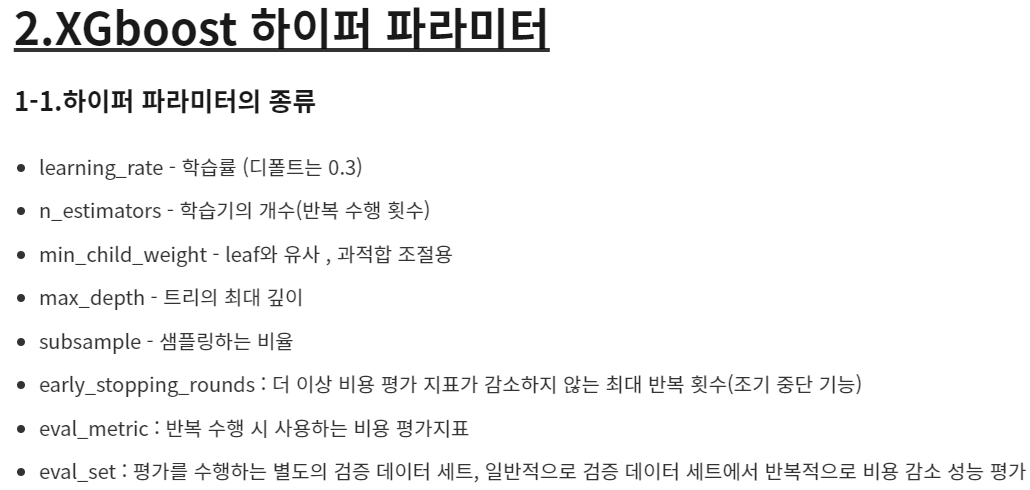

In [ ]:

for i in range(3, 30):
    print(f'{i-2}번째 , max_depth : {i}학습 시작 합니당 ! ')
    print('\n')
    xgb = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_estimators=400, learning_rate=0.2, max_depth=i)
    xgb.fit(X_train, y_train,
           early_stopping_rounds = 100, # 이걸로 성능이 향상되지안흔부분찾기
           eval_metric = 'rmse',
           eval_set = [(X_test, y_test)],
           verbose = True) #원래는 새로운 데이터넣어줘야 검증됨
    print('\n')
    print('\n')


1번째 , max_depth : 3학습 시작 합니당 ! 




`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


xgb.set_param({"predictor": "gpu_predictor"})
shap_values = xgb.predict(dtrain, pred_contribs=True)
shap_interaction_values = model.predict(dtrain, pred_interactions=True)

In [99]:
xgb.feature_importances_

array([0.05192265, 0.0338917 , 0.352875  , 0.05116682, 0.02249818,
       0.04812388, 0.03061993, 0.04586525, 0.03094465, 0.03455671,
       0.08226822, 0.02579672, 0.06164747, 0.06641227, 0.03101726,
       0.03039323], dtype=float32)

In [104]:
df_imp = pd.DataFrame(xgb.feature_importances_, columns=['수치'])
df_imp['feature'] = X.columns.tolist()
df_imp[['feature', '수치']].sort_values(by='수치', ascending=False)

,feature,수치
2,일산화탄소,0.352875
10,이슬점온도(°C),0.082268
13,month,0.066412
12,year,0.061647
0,오존,0.051923
3,아황산가스,0.051167
5,강수량(mm),0.048124
7,풍향(16방위),0.045865
9,증기압(hPa),0.034557
1,이산화질소,0.033892


<BarContainer object of 16 artists>

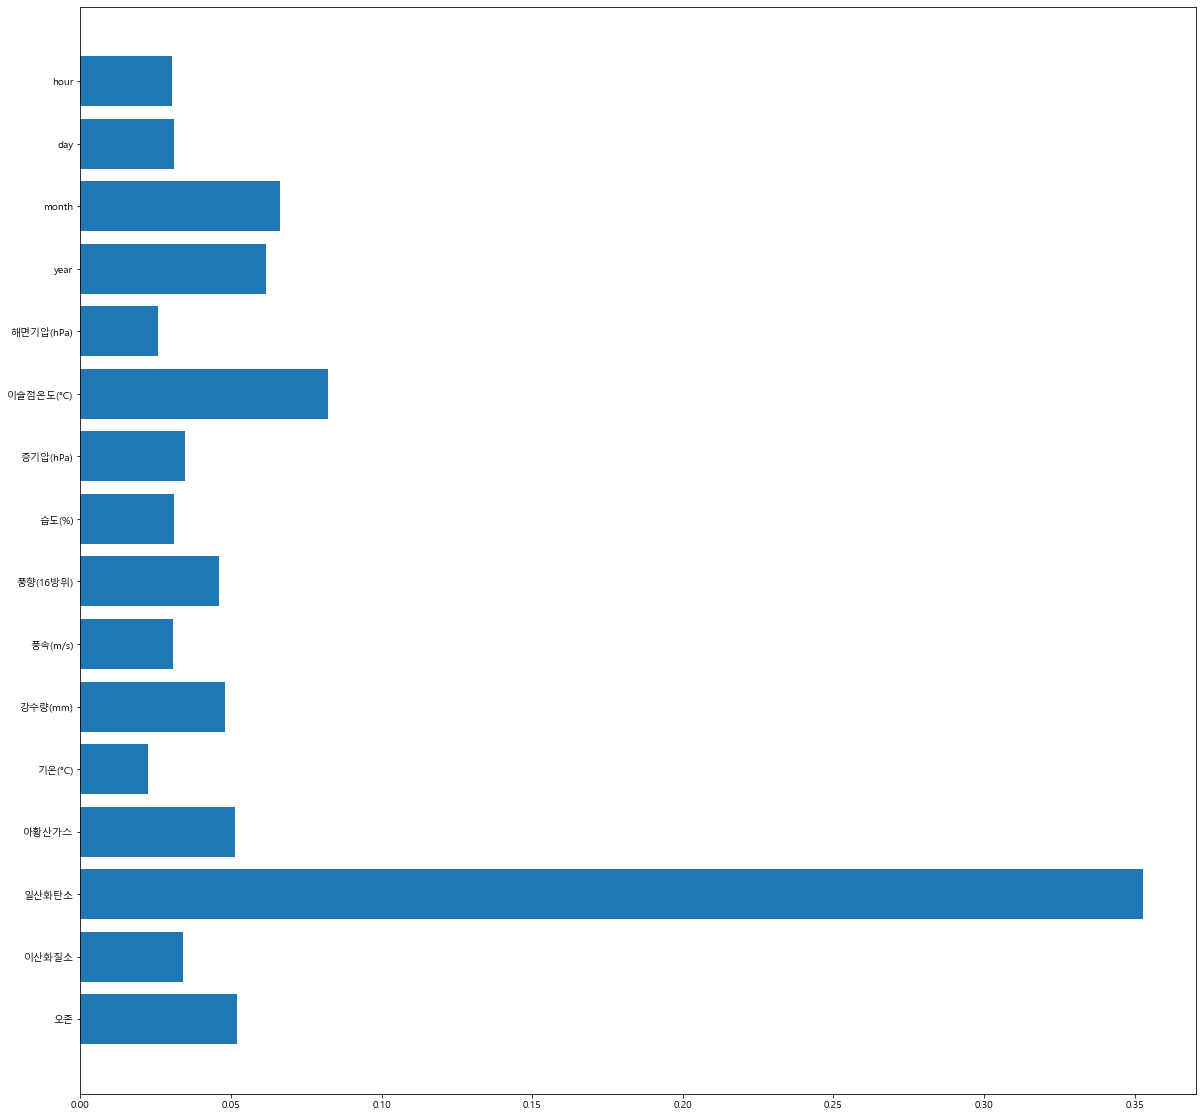

In [105]:
plt.figure(figsize=(20, 20))
plt.barh(X.columns.tolist(), xgb.feature_importances_)

In [106]:
X_fn = X.columns.tolist()

Text(0.5, 0, 'Xgboost Feature Importance')

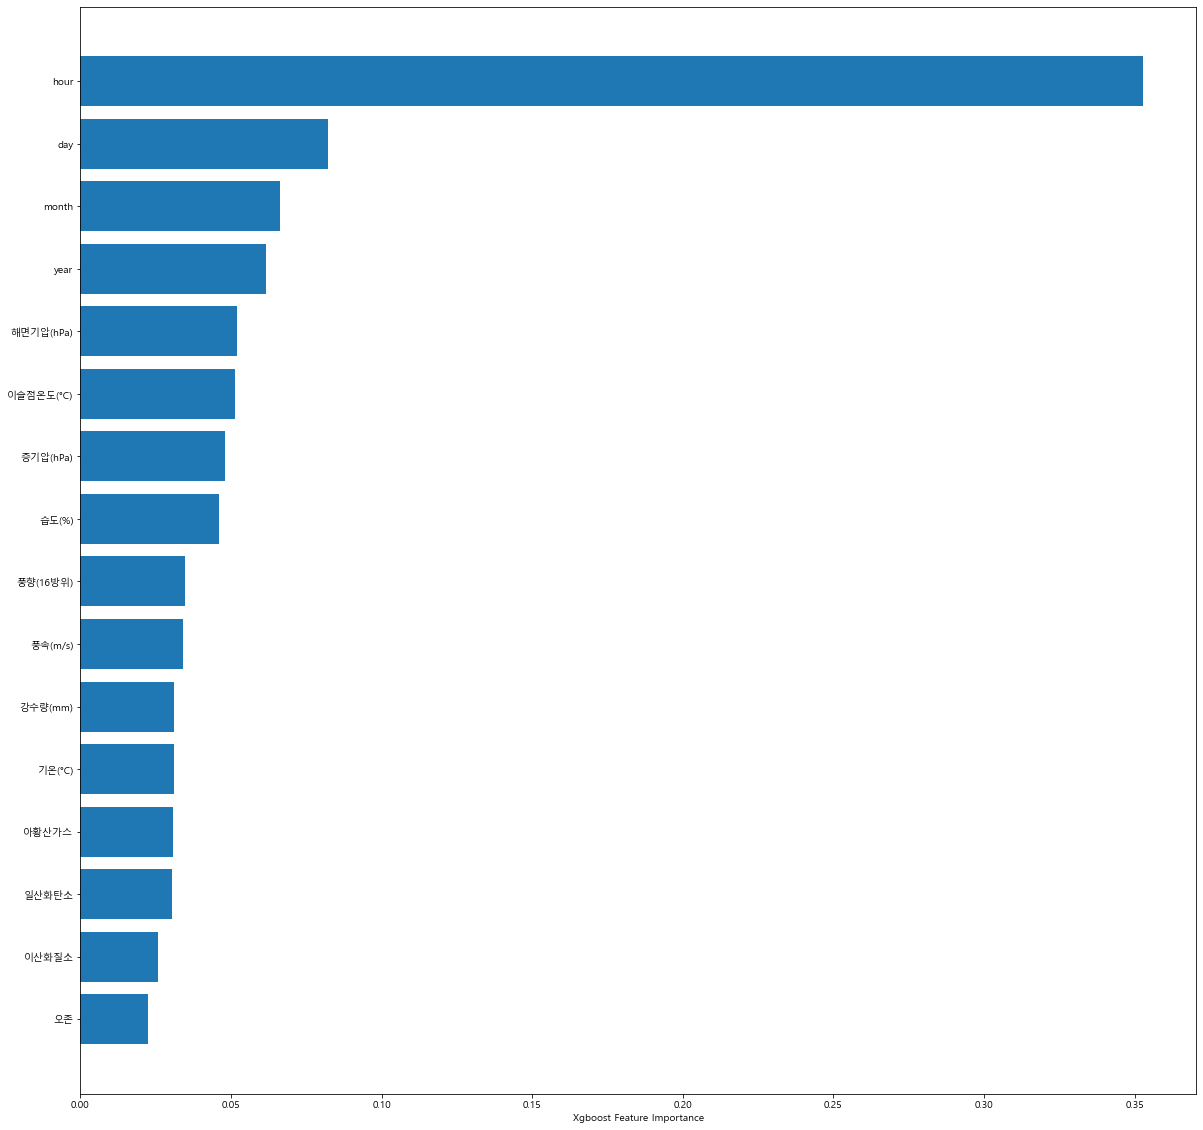

In [107]:
sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(X_fn, xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

**Permutation Based Feature Importance**

In [108]:
perm_importance = permutation_importance(xgb, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

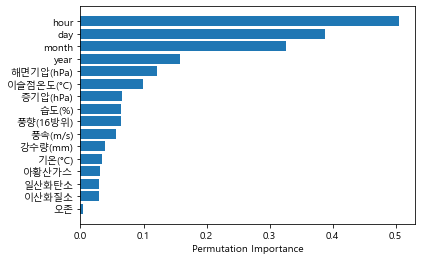

In [109]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns.tolist(), perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


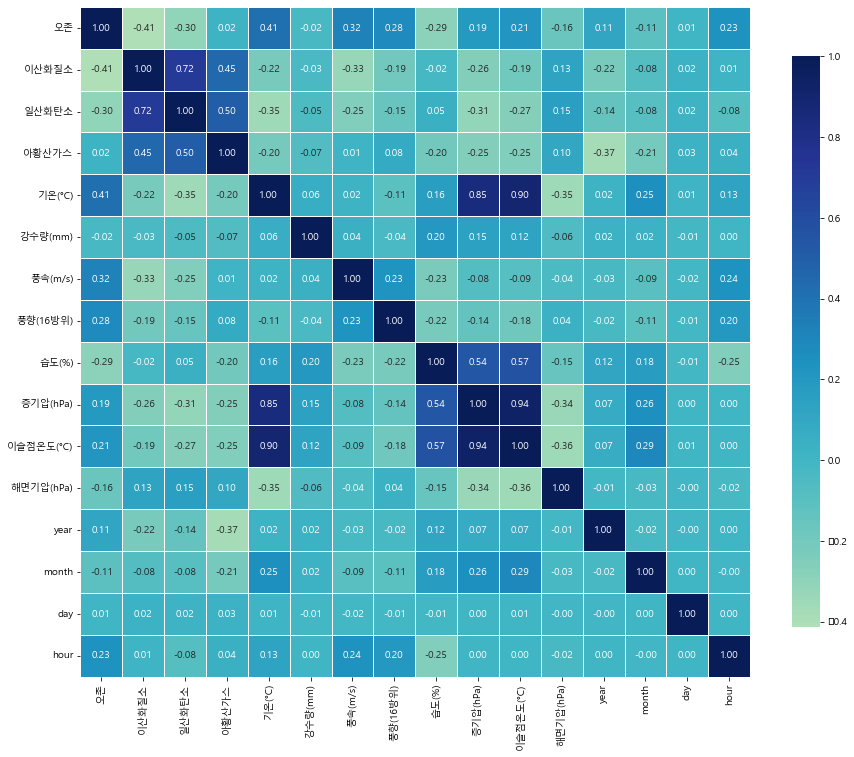

In [110]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[X.columns.tolist()])

**Feature Importance Computed with SHAP Values**

In [111]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


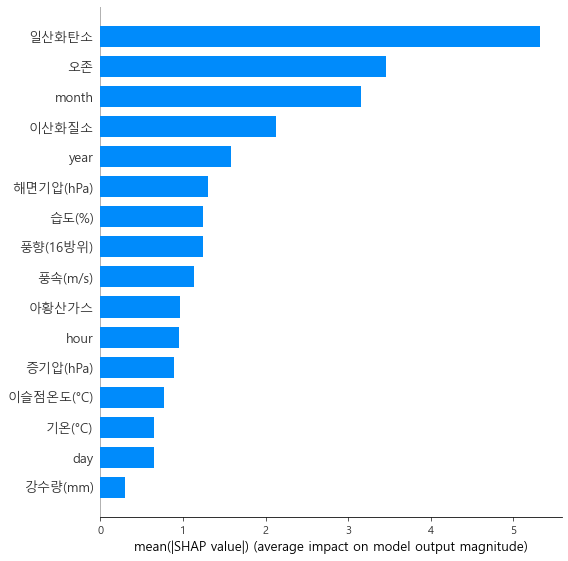

In [112]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


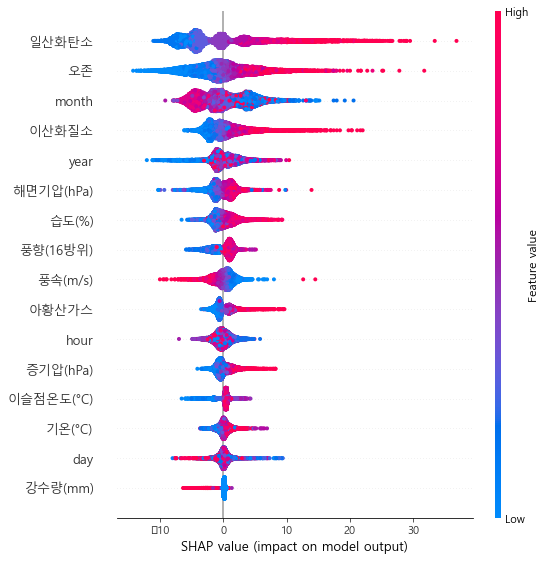

In [113]:
shap.summary_plot(shap_values, X_test)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


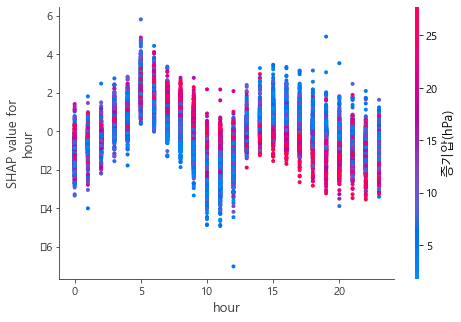

In [114]:
shap.dependence_plot("hour", shap_values, X_test)

In [95]:
df_input.iloc[6:]

,날짜,PM10,PM2.5,오존,이산화질소,일산화탄소,아황산가스,기온(°C),강수량(mm),풍속(m/s),...,지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),year,month,day,hour,6h_PM2.5
6,2015-01-01 07:00:00,139,19,0.019,0.011,0.6,0.006,-9.5,0.0,4.5,...,-6.8,-5.2,-2.8,-0.1,0.7,2015,1,1,7,8.000000
7,2015-01-01 08:00:00,132,16,0.018,0.011,0.6,0.006,-9.8,0.0,6.1,...,-7.0,-5.4,-2.9,-0.2,0.7,2015,1,1,8,20.000000
8,2015-01-01 09:00:00,121,14,0.017,0.011,0.6,0.006,-9.5,0.0,5.1,...,-6.0,-4.9,-3.0,-0.3,0.7,2015,1,1,9,8.000000
9,2015-01-01 10:00:00,94,16,0.020,0.010,0.6,0.006,-8.6,0.0,5.4,...,-3.0,-3.9,-2.7,-0.4,0.7,2015,1,1,10,7.000000
10,2015-01-01 11:00:00,80,14,0.022,0.009,0.6,0.006,-7.9,0.0,4.5,...,-0.2,-2.8,-2.3,-0.4,0.6,2015,1,1,11,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69516,2022-12-06 19:00:00,17,8,0.017,0.032,0.4,0.003,2.8,0.0,2.3,...,-0.1,1.9,1.8,2.4,4.0,2022,12,6,19,22.035155
69517,2022-12-06 20:00:00,19,11,0.017,0.031,0.4,0.003,2.9,0.0,2.7,...,-0.1,1.9,1.8,2.5,4.0,2022,12,6,20,22.035155
69518,2022-12-06 21:00:00,17,10,0.018,0.029,0.4,0.003,2.5,0.0,2.4,...,-0.2,1.9,1.8,2.5,4.0,2022,12,6,21,22.035155
69519,2022-12-06 22:00:00,18,7,0.017,0.030,0.4,0.003,2.2,0.0,1.9,...,-0.3,1.9,1.8,2.5,4.0,2022,12,6,22,22.035155


In [164]:
numeric_pipe = make_pipeline(SimpleImputer(), MinMaxScaler())
# category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

numeric_list = X.describe().columns.tolist()
# category_list = X.describe(include='object').columns.tolist()

preprocessing_pipe = make_column_transformer((numeric_pipe, numeric_list), 
#                                              (category_pipe, category_list)
                                            )

In [144]:
grid_model.best_score_

0.7174273827389352

In [146]:
best_model.score

<bound method Pipeline.score of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['오존', '이산화질소', '일산화탄소',
                                                   '아황산가스', '기온(°C)', '강수량(mm)',
                                                   '풍속(m/s)', '풍향(16방위)',
                                                   '습도(%)', '증기압(hPa)',
                                                   '이슬점온도(°C)', '해면기압(hPa)',
                                                   'year', 'month', 'day',
                                                   'hour'])])),
            

In [165]:
model_pipe = make_pipeline(preprocessing_pipe, XGBRegressor(tree_method='gpu_hist', gpu_id=0))

hyperparameter_list = {
 'xgbregressor__max_depth':range(5,25),
 'xgbregressor__min_depth':range(5,25)
}


xgb_param_grid={
    'xgbregressor__n_estimators' : [100,200,300,400,500],
    'xgbregressor__learning_rate' : [0.01,0.05,0.1,0.15],
    'xgbregressor__max_depth' : [3,5,7,10,15],
     'xgbregressor__min_depth' : [3,5,7,10,15],
    
}

# grid_model = GridSearchCV(model_pipe, cv=5, param_grid={}, n_jobs=-1)

grid_model = GridSearchCV(estimator = model_pipe,
                        param_grid = {},
                        cv = 5,
                        # scoring='neg_mean_squared_error',
                        scoring = 'neg_root_mean_squared_error',
                        n_jobs = -1,
                        verbose = 10)
grid_model.fit(X_train, y_train)

# 6. 평가
best_model = grid_model.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


print(f'y_train_pred : {y_train_pred}\n')
print(f'y_test_pred : {y_test_pred}\n')
# 평가
print(f'r2_score_train : {r2_score(y_train, y_train_pred)}\n')
print(f'r2_score_test : {r2_score(y_test, y_test_pred)}\n')



print('explained_variance_score: {}'.format(explained_variance_score(y_train, y_train_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_train, y_train_pred)))
print('r2_score: {}'.format(r2_score(y_train, y_train_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))


print('explained_variance_score: {}'.format(explained_variance_score(y_test, y_test_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_test_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_test_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

ValueError: Found input variables with inconsistent numbers of samples: [52140, 25000]

In [166]:


print('explained_variance_score: {}'.format(explained_variance_score(y_train, y_train_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_train, y_train_pred)))
print('r2_score: {}'.format(r2_score(y_train, y_train_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print('\n')
print('explained_variance_score: {}'.format(explained_variance_score(y_test, y_test_pred)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, y_test_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_test_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

ValueError: Found input variables with inconsistent numbers of samples: [25000, 52140]

In [ ]:
# 참고 : https://dacon.io/en/competitions/official/235927/codeshare/6066

def modelfit(pip_xgb, grid_param_xgb, x, y) : 
    gs_xgb = (GridSearchCV(estimator=pip_xgb,
                        param_grid=grid_param_xgb,
                        cv=4,
                        # scoring='neg_mean_squared_error',
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        verbose=10))

    gs_xgb = gs_xgb.fit(x, y)
    print('Train Done.')

    #Predict training set:
    y_pred = gs_xgb.predict(x)

    #Print model report:
    print("\nModel Report")
    print("\nCV 결과 : ", gs_xgb.cv_results_)
    print("\n베스트 정답률 : ", gs_xgb.best_score_)
    print("\n베스트 파라미터 : ", gs_xgb.best_params_)

In [162]:
print("\nModel Report")
print("\nCV 결과 : ", grid_model.cv_results_)
print("\n베스트 정답률 : ", grid_model.best_score_)
print("\n베스트 파라미터 : ", grid_model.best_params_)


Model Report

CV 결과 :  {'mean_fit_time': array([5.02656207]), 'std_fit_time': array([0.04366987]), 'mean_score_time': array([0.0374999]), 'std_score_time': array([0.00406907]), 'params': [{}], 'split0_test_score': array([-9.247087]), 'split1_test_score': array([-9.41380356]), 'split2_test_score': array([-9.26715604]), 'split3_test_score': array([-9.37619337]), 'split4_test_score': array([-9.34708251]), 'mean_test_score': array([-9.3302645]), 'std_test_score': array([0.06367457]), 'rank_test_score': array([1])}

베스트 정답률 :  -9.330264495413838

베스트 파라미터 :  {}


In [ ]:
# Mean Squrd Error
print(f'MSE : {mean_squared_error(y_train, y_train_pred)}')

# Root Mean Squrd Error
print(f'RMSE : {np.sqrt(mean_squared_error(y_train, y_train_pred))}')

# Root Mean Absolute Error
print(f'MAE : {mean_absolute_error(y_train, y_train_pred)}')

def Mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

# Mean Absolute Percentage Error
print(f'MAPE : {Mean_absolute_percentage_error(y_train, y_train_pred)}') # Mean_absolute_percentage_error

print(f'R2 : {r2_score(y_train, y_train_pred)}') # r2_score

In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
 
# Load the data
dataset = pd.read_csv("boston_house.csv")
X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
 
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)
 
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xg.DMatrix(data = train_X, label = train_y)
test_dmatrix = xg.DMatrix(data = test_X, label = test_y)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:linear"}
 
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
 
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))